# Apply Naive-Bayes on Amazon fine food reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given the Amazon fine food review dataset, apply time based splitting of the reviews. Make 70% of them as Train dataset and remaining as Test dataset.
Apply 10-fold cross validation on Train dataset to find alpha for naive-bayes, feature importance of positive and negative reviews, precision, accuracy, recall, F1 score, confusion matrix . Find Test accuracy of Test data and confusion matrix. Use BoW, TF-IDF, Avg-Word2Vec, TF-IDF-Word2Vec to vectorise the reviews.

In the t-SNE assignmnet, we have already did the data cleanup like deduplication, stemming, stop-word removal and Lemmatization. So here we are not doing the same thing again. We simply use those stored cleaned text for further analysis.






## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 


In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read filtered data 
#where ProfileName like 'em%'
con = sqlite3.connect('final.sqlite') 

#getting the dataset into a dataframe 
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""", con) 
final_train = pd.read_sql_query("""
SELECT * FROM Reviews order by Time 
limit cast(0.7*(select count(*) from Reviews) as integer) 
""" , con) 
final_test = pd.read_sql_query("""
SELECT * FROM Reviews order by Time desc
limit cast(0.3*(select count(*) from Reviews) as integer) 
""" , con) 

In [3]:
final.head()

index      Id   ProductId          UserId               ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
1  138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
2  417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
3  346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
4  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

   HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
0                     0                       0      5  939340800   
1                     2                       2      5  940809600   
2                     0                       0      5  944092800   
3                     1                       2      5  944438400   
4                     0                       0      5  946857600   

                                             Summary  \
0                          EVERY book is educational   
1  This whole series is great way to spend time w...   
2                               Entertainingl Funny!   
3                            A modern day fairy tale   
4                                         FANTASTIC!   

                                                Text positiveNegative  \
0  this witty little book makes my son laugh at l...         positive   
1  I can remember seeing the show when it aired o...         positive   
2  Beetlejuice is a well written movie ..... ever...         positive   
3  A twist of rumplestiskin captured on film, sta...         positive   
4  Beetlejuice is an excellent and funny movie. K...         positive   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'rememb see show air televis year ago child s...  
2  b'beetlejuic well written movi everyth excel a...  
3  b'twist rumplestiskin captur film star michael...  
4  b'beetlejuic excel funni movi keaton hilari wa...

In [4]:
print(final.shape)
print(final_train.shape)
print(final_test.shape)

(364171, 13)
(254919, 13)
(109251, 13)


# Bag of Words (BoW)

In [5]:
count_vect = CountVectorizer() #in scikit-learn
final_train_X = count_vect.fit_transform(final_train['CleanedText'].values)
final_train_Y = final_train['positiveNegative'].values
final_test_X =  count_vect.transform(final_test['CleanedText'].values)
final_test_Y = final_test['positiveNegative'].values

C:\Users\Swapnanil\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



The optimal value of alpha is 1.00000000.


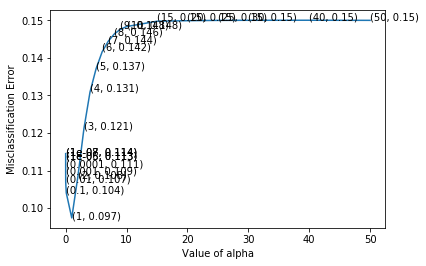

the misclassification error for each k value is :  [0.114 0.114 0.113 0.113 0.111 0.109 0.107 0.104 0.097 0.108 0.121 0.131
 0.137 0.142 0.144 0.146 0.148 0.148 0.15  0.15  0.15  0.15  0.15  0.15 ]


In [6]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_train_X, final_train_Y, 
                                                                     test_size=0.3, random_state=42)
#clf = BernoulliNB(binarize=1)
#clf.fit(X_train, Y_train)
#print(clf.predict(X_test[2:3]))

# creating list of alpha for NB
myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    #print((nb))

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [7]:
#Finding top 10 important features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])


Postive top 10 important features are:
('like', -4.444011085613443)
('tast', -4.51426792968355)
('good', -4.649293762950087)
('flavor', -4.670882981304331)
('love', -4.699096964570424)
('great', -4.719491079019004)
('use', -4.741244269360369)
('one', -4.797570713871195)
('product', -4.883810709990517)
('tea', -4.891354136409893)


Negative top 10 important features are:
('tast', -4.239537630748643)
('like', -4.320779248452499)
('product', -4.488506458708635)
('one', -4.763496894718443)
('flavor', -4.805309933663004)
('tri', -4.914608058527804)
('would', -4.9151140033906096)
('good', -5.071558697973897)
('coffe', -5.097334350731513)
('use', -5.1043419455480965)


In [8]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy of the model at optimal hyperparameter alpha = 1 is:  89.557990%
Confusion matrix for the model is:


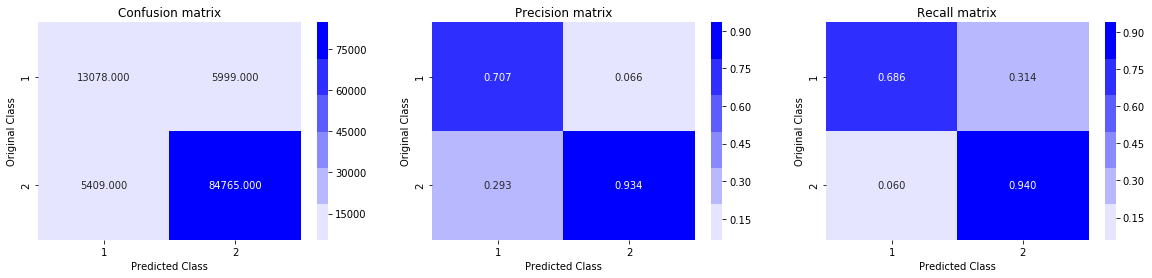

Recall value for the positive class of the model is: 0.9400159691263558
Precision value for the positive class of the model is: 0.9339055131990657
F1 score for the positive class of the model is: 0.9369507787197824


In [9]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])


Observation: We found that K=1 is the optimal value. And accuracy on the test dataset is 89.557990%

In [10]:
print(final_train_X.shape)
print(final_test_X.shape)

(254919, 59194)
(109251, 59194)


# TF-IDF

In [11]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train_X = tf_idf_vect.fit_transform(final_train['CleanedText'].values)
final_tf_idf_train_Y = final_train['positiveNegative'].values
final_tf_idf_test_X = tf_idf_vect.transform(final_test['CleanedText'].values)
final_tf_idf_test_Y = final_test['positiveNegative'].values
print(final_tf_idf_train_X.get_shape())
print(final_tf_idf_train_Y.shape)
print(final_tf_idf_test_X.get_shape())
print(final_tf_idf_test_Y.shape)

(254919, 2307509)
(254919,)
(109251, 2307509)
(109251,)


In [12]:
features = tf_idf_vect.get_feature_names()
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf_train_X[1,:].toarray()[0],features,25)
print(top_tfidf)

            feature     tfidf
0         book song  0.177012
1      child sister  0.177012
2    school purchas  0.177012
3    preschool turn  0.177012
4   teach preschool  0.177012
5      whole school  0.177012
6      song student  0.177012
7       air televis  0.177012
8      sister later  0.177012
9              book  0.174366
10  children tradit  0.171386
11         use seri  0.171386
12         show air  0.171386
13     televis year  0.171386
14    thirti someth  0.171386
15    student teach  0.171386
16        ago child  0.167393
17    book children  0.167393
18      tradit live  0.167393
19       day thirti  0.167393
20        seri book  0.161767
21       along book  0.161767
22         see show  0.154678
23       turn whole  0.151037
24     later bought  0.148155



The optimal value of alpha is 0.00100000.


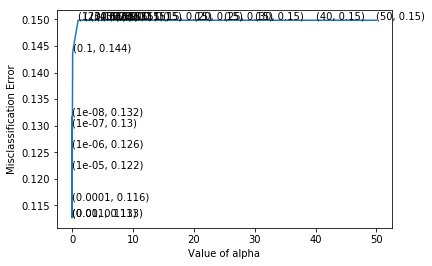

the misclassification error for each k value is :  [0.132 0.13  0.126 0.122 0.116 0.113 0.113 0.144 0.15  0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15 ]


In [13]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_tf_idf_train_X, final_tf_idf_train_Y, 
                                                                     test_size=0.3, random_state=42)
#clf = BernoulliNB(binarize=1)
#clf.fit(X_train, Y_train)
#print(clf.predict(X_test[2:3]))

# creating list of alpha for NB
myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    #print((nb))

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [14]:
#Finding top 10 important features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    



Postive top 10 important features are:
('great', -6.214908305108226)
('love', -6.223800110468767)
('tast', -6.271516958483198)
('tea', -6.276004958192765)
('like', -6.280537022492241)
('good', -6.282728795103455)
('flavor', -6.342825825864094)
('coffe', -6.366835358668578)
('use', -6.447703493948013)
('product', -6.457243596923904)


Negative top 10 important features are:
('tast', -5.972647197482666)
('like', -6.115270308297991)
('product', -6.159475254340928)
('would', -6.459222687058151)
('flavor', -6.476005432312708)
('coffe', -6.479861593208945)
('one', -6.499791469080046)
('tri', -6.604188933571626)
('buy', -6.629491714450055)
('order', -6.6337315762164994)


Accuracy of the model at optimal hyperparameter alpha = 0.001000 is:  87.705376%
Confusion matrix for the model is:


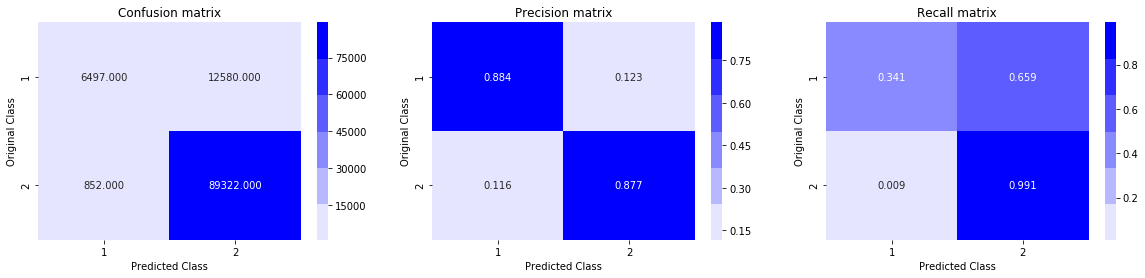

Recall value for the positive class of the model is: 0.9905516002395369
Precision value for the positive class of the model is: 0.8765480559753489
F1 score for the positive class of the model is: 0.9300693475499282


In [19]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
Y_pred = nb.predict(final_tf_idf_test_X)
Y_test_accuracy = accuracy_score(final_tf_idf_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_tf_idf_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_tf_idf_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])


Observation: We found that alpha=0.001 is the optimal value. And accuracy on the test dataset is 87.705376%.